## 1. Import the libraries and dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk

# Downloads the NLTK package
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

dataset = pd.read_csv('Restaurant_Reviews.tsv', delimiter='\t')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leticiachoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/leticiachoo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/leticiachoo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Text pre-processing

The compound is calculated [using the sum of `score/math.sqrt(score^2 + alpha)`](https://stackoverflow.com/questions/40325980/how-is-the-vader-compound-polarity-score-calculated-in-python-nltk) for positive/negative/neutral scorings, where `alpha=15` by default and is a random score.

In [2]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# Tokenizer removes punctuations
tokenizer = RegexpTokenizer(r'\w+')

# Lemmatizer
wl = WordNetLemmatizer()

# Stopword remover - we want to keep "not"
sw = stopwords.words('english')
sw.remove('not')
sw = set(sw)


def preprocess(sentence):
    # Tokenize word to split into tokens array
    words = tokenizer.tokenize(sentence.lower())
    words_lem = []
    
    for w in words:
        w = wl.lemmatize(w) if w not in sw else w

        # Remove another round after lemmatized replacement word
        if w not in sw:
            words_lem.append(w)

    return ' '.join(words_lem)


corpus = [preprocess(dataset['Review'][i]) for i in range(0, len(dataset))]

## 3. Text vectorize and translate into features

This will pick the top `1500` frequent words (or features). 

We want to compare unigram vs bigram vs TF-IDF vectorizers.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

y = dataset.iloc[:, -1].values

# Unigram vectorizer
ug = CountVectorizer(max_features=1500)
ug_x = ug.fit_transform(corpus).toarray()

# Bigram vectorizer
bg = CountVectorizer(max_features=1500, ngram_range=(2,2))
bg_x = bg.fit_transform(corpus).toarray()

# TF-IDF vectorizer
tf = TfidfVectorizer(max_features=1500)
tf_x = tf.fit_transform(corpus).toarray()

## 4. Print stop words and top 20 features

The "top" 20 features are determined by highest word count.

In [4]:
ug_sw = ug.stop_words_
ug_top = sorted(ug.vocabulary_.items(), key=lambda x: x[1], reverse=True)[0:10]

print('===== Unigram =====')
print(f'Stopwords count: {len(ug_sw)}')
print(f'Top words:\n', pd.DataFrame(ug_top, columns=['Word', 'Count']),'\n')

bg_sw = bg.stop_words_
bg_top = sorted(bg.vocabulary_.items(), key=lambda x: x[1], reverse=True)[0:10]

print('===== Bigram =====')
print(f'Stopwords count: {len(bg_sw)}')
print(f'Top words:\n', pd.DataFrame(bg_top, columns=['Word', 'Count']),'\n')

tf_idf_map = dict(zip(tf.get_feature_names(), tf.idf_))
tf_sw = tf.stop_words_
tf_top = sorted(tf.vocabulary_.items(), key=lambda x: x[1], reverse=True)[0:10]
tf_top = [(w[0], w[1], tf_idf_map[w[0]]) for w in tf_top]

print('===== TF-IDF =====')
print(f'Stopwords count: {len(tf.stop_words_)}')
print(f'Top words:\n', pd.DataFrame(tf_top, columns=['Word', 'Count', 'IDF score']),'\n')

===== Unigram =====
Stopwords count: 284
Top words:
          Word  Count
0        zero   1499
1       yummy   1498
2         yum   1497
3       yukon   1496
4       yucky   1495
5         yet   1494
6     yelpers   1493
7  yellowtail   1492
8      yellow   1491
9        year   1490 

===== Bigram =====
Stopwords count: 2692
Top words:
               Word  Count
0        zero star   1499
1      yummy tummy   1498
2        yummy try   1497
3  yummy christmas   1496
4          yum yum   1495
5        yum sauce   1494
6       yukon gold   1493
7        yet still   1492
8    yet delicious   1491
9      yet another   1490 

===== TF-IDF =====
Stopwords count: 284
Top words:
          Word  Count  IDF score
0        zero   1499   6.299317
1       yummy   1498   6.299317
2         yum   1497   7.215608
3       yukon   1496   7.215608
4       yucky   1495   7.215608
5         yet   1494   6.522460
6     yelpers   1493   7.215608
7  yellowtail   1492   7.215608
8      yellow   1491   7.215608
9

## 5. Train the Naive Bayes model on the Training set after Splitting

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

def get_predictions(x):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

    model = GaussianNB()
    model.fit(x_train, y_train)

    return model.predict(x_test), y_test

## 6. Display graph and results

         Correct pred.  Incorrect pred.  Accuracy score
Unigram            137               63           0.685
Bigram             125               75           0.625
TF-IDF             138               62           0.690


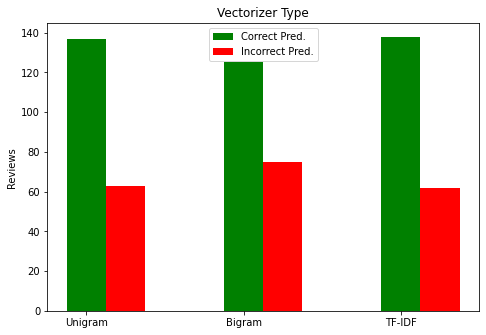

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Get results for unigram
ug_y_pred, ug_y_test = get_predictions(ug_x)
ug_cm = confusion_matrix(ug_y_pred, ug_y_test)

# Get results for bigram
bg_y_pred, bg_y_test = get_predictions(bg_x)
bg_cm = confusion_matrix(bg_y_pred, bg_y_test)

# Get results for TF-IDF
tf_y_pred, tf_y_test = get_predictions(tf_x)
tf_cm = confusion_matrix(tf_y_pred, tf_y_test)

data = [
    [ug_cm[0][0] + ug_cm[1][1], bg_cm[0][0] + bg_cm[1][1], tf_cm[0][0] + tf_cm[1][1]],
    [ug_cm[0][1] + ug_cm[1][0], bg_cm[0][1] + bg_cm[1][0], tf_cm[0][1] + tf_cm[1][0]]
]

print(pd.DataFrame([
    [data[0][0], data[1][0], accuracy_score(ug_y_test, ug_y_pred)],
    [data[0][1], data[1][1], accuracy_score(bg_y_test, bg_y_pred)],
    [data[0][2], data[1][2], accuracy_score(tf_y_test, tf_y_pred)] 
], columns=['Correct pred.', 'Incorrect pred.', 'Accuracy score'], index=['Unigram', 'Bigram', 'TF-IDF']))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
width = 0.25

ax.set_ylabel('Reviews')
ax.set_title('Vectorizer Type')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('Unigram', 'Bigram', 'TF-IDF'))

ax.bar(np.arange(3), data[0], color='g', width=width, label='Correct Pred.')
ax.bar(np.arange(3) + width, data[1], color='r', width=width, label='Incorrect Pred.')
ax.legend()